In [246]:
from sklearnex import patch_sklearn
patch_sklearn()
import cv2
from sklearn.cluster import KMeans
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
import pandas as pd
import os
from math import floor,sqrt,ceil,log2
from moviepy.editor import VideoFileClip
import librosa
from sklearn.preprocessing import StandardScaler, LabelEncoder
import h5py
from sklearn.metrics import precision_score, recall_score, f1_score
import objectDetection as od
from tabulate import tabulate
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
import isodata

from transformers import BertTokenizer, BertModel

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Video Summarization

### Preprocessing and Feature Extraction


#### a. Video Processing and Frame Extraction


In [247]:
def extract_frames(video_path, frame_rate=2):
    video = cv2.VideoCapture(video_path)
    count = 0
    success = True
    frames = []
    
    while success:
        success, image = video.read()
        if count % frame_rate == 0 and success:
            frames.append(image)
        count += 1

    video.release()
    return frames

#### b. Audio Extraction


In [248]:

def extract_audio_from_video(video_path, output_audio_path):
    video = VideoFileClip(video_path)
    audio = video.audio
    audio.write_audiofile(output_audio_path)
    video.close()

#### c.Audio Features

In [249]:
def extract_audio_features_for_each_frame(audio_path, frame_rate=30,num_frames=None):
    y, sr = librosa.load(audio_path)
    
    # frame_rate 1/1 = 30
    # frame_rate 1/2 = 15

    # Calculate the number of audio samples per video frame
    samples_per_frame = sr / frame_rate

    # Initialize an array to store MFCCs for each frame
    mfccs_per_frame = []

    # Iterate over each frame and extract corresponding MFCCs
    for frame in range(int(len(y) / samples_per_frame)):
        start_sample = int(frame * samples_per_frame)
        end_sample = int((frame + 1) * samples_per_frame)

        # Ensure the end sample does not exceed the audio length
        end_sample = min(end_sample, len(y))

        # Extract MFCCs for the current frame's audio segment
        mfccs_current_frame = librosa.feature.mfcc(y=y[start_sample:end_sample], sr=sr, n_mfcc=130)
        mfccs_processed = np.mean(mfccs_current_frame.T, axis=0)
        mfccs_per_frame.append(mfccs_processed)

    if(len(mfccs_per_frame)>num_frames):
        return mfccs_per_frame[:num_frames]
    return mfccs_per_frame


#### d. Feature Extraction (example with visual features using a CNN)


In [250]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
import cv2
import h5py

# model = VGG16(weights='imagenet', include_top=False)

# Load the weights from the downloaded file
base_model = VGG16(weights=None, include_top=False)
weights_path = 'vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5' # Replace with the actual path
base_model.load_weights(weights_path)

# Create a new Sequential model and add the VGG16 base model
model = Sequential()
model.add(base_model)

def extract_visual_features(frames):
    features = []
    for frame in frames:
        if frame is not None:
            img = cv2.resize(frame, (224, 224))  # Resize frame to 224x224
            img = img_to_array(img)              # Convert to array
            img = np.expand_dims(img, axis=0)    # Add batch dimension
            img = preprocess_input(img)          # Preprocess for VGG16
            
            feature = model.predict(img,use_multiprocessing=True,workers=4)
            features.append(feature.flatten())

    return features

### Connect Audio/Annotation/Video

#### Annotation To List

In [251]:
def annotation2List(annotation_features):
    # Make the string '1,1,1,3,2,2,4,4,1' to float list
    annotation_float_array=[]
    for annotation in annotation_features:
        
        if isinstance(annotation,str):
            annotation = annotation.split(',')
        if isinstance(annotation,list):
            for anno in annotation:
                annotation_float_array.append(float(anno))
        else:
            annotation_float_array.append(float(annotation))
    return annotation_float_array

#### Title Tokenized

In [252]:
def tfTitle(info_file,video_path):
    info_df = pd.read_csv(info_file, sep='\t')
    info_video=info_df[info_df['video_id']==video_path.split('/')[-1].split('.')[0]]
    title=info_video['title'].values[0]
    # Preprocess titles and extract features (TF-IDF or word embeddings)
    # For TF-IDF:
    print('title:',title)

    title_features = tokenizer.encode(title, add_special_tokens=False)
    return np.array(title_features)

#### Extract Data

In [253]:
def extractData(video_path, anno_file, info_file,flag_to_extract):
    
    return_data=[]
    # Extract frames from the video
    if(flag_to_extract[0]):
        frames = extract_frames(video_path)
        return_data.append(['frames',frames])
    else:
        return_data.append(None)

    # # Extract visual features
    if(flag_to_extract[1]):
        visual_features = extract_visual_features(frames) 
        return_data.append(['visual',visual_features])
    else:
        return_data.append(None)

    # Extract audio
    if(flag_to_extract[2]):
        audio_output_path = 'datasets/extractedAudio/extracted_audio.wav'
        extract_audio_from_video(video_path, audio_output_path) 

        # Extract audio features
        audio_features = extract_audio_features_for_each_frame(audio_output_path,15,len(frames))
        return_data.append(['audio',audio_features])
    else:
        return_data.append(None)

    # Load titles from info file
    if(flag_to_extract[3]):
        title_features = tfTitle(info_file,video_path)
        return_data.append(['title',title_features])
    else:
        return_data.append(None)

    return return_data


### Kmeans and feature connection

##### Detect objects and return padded encoded

In [254]:
def detectObjects(frames, yolo_model, classes, objects=None,video=None):
    if objects is None:
        print('Detecting objects in frames...')
        yolo_model, classes = loadYOLOv5()
        
        objects = od.detect_objects_in_all_frames(frames, yolo_model, classes)
        saveData('objects',objects,video)

    # Here, taking the first detected object
    objects = [frame_objects[0] if frame_objects else 'None' for frame_objects in objects]

    # One-hot encoding of objects
    encoded_objects=[]
    for object in objects:
        encoded_objects.append(tokenizer.encode(object, add_special_tokens=True))
    encoded_objects = np.array(encoded_objects)

    # Padding not required as one-hot encoding ensures consistent vector length
    
    return encoded_objects, objects

##### plot Data $Remove it later

In [255]:
def plotData(combined_features_normalized, kmeans):

    plt.figure(figsize=(20, 12))
    plt.scatter(combined_features_normalized[:, 0], combined_features_normalized[:, 1], c=kmeans.labels_, cmap='viridis', marker='o', s=5)  # Reduced size

    # Add labels to each point
    for i, label in enumerate(kmeans.labels_):
        plt.text(combined_features_normalized[i, 0], combined_features_normalized[i, 1], str(label), fontsize=8)  # Reduced fontsize

    plt.title('KMeans Clustering')
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    plt.colorbar(label='Cluster Label')
    plt.show()

In [256]:
def most_frequent_in_rows(array):
    most_frequent = []
    for row in array:
        counts = np.bincount(row)
        most_frequent_number = np.argmax(counts)
        most_frequent.append(most_frequent_number)
    return most_frequent

##### Save Data if ness

In [257]:
import pickle
def saveData(name,feature,video):
    if not os.path.exists(f'video_ext_data/{video}'):
        os.makedirs(f'video_ext_data/{video}')
    with open(f'video_ext_data/{video}/{name}.pkl', 'wb') as f:
        pickle.dump(feature,f)

##### Load Data if ness

In [258]:
import pickle
def getData(feature,video):
    if os.path.exists(f'video_ext_data/{video}/{feature}.pkl'):
        with open(f'video_ext_data/{video}/{feature}.pkl', 'rb') as f:
            feature = pickle.load(f)
        return feature
    else:
        return None

### Kmeans

In [259]:
def MultiModalKMeans(video_path, anno_file, info_file,num_clusters=None,getDataFlag=False):
    """
    Integrate visual, audio, and annotation features from a video,
    and perform clustering on the combined features.

    :param video_path: Path to the video file.
    :param anno_file: Path to the annotation file.
    :param info_file: Path to the info file.
    :param num_clusters: Number of clusters to use in KMeans.
    :return: Cluster labels for each data point.
    """
    
    # Extract data from video
    objects=None
    
    video=video_path.split('/')[-1].split('.')[0]
    
    # GetData
    objects=getData('objects',video)
    frames=getData('frames',video)
    visual_features=getData('visual',video)
    audio_features=getData('audio',video)
    title_features=getData('title',video)
    
    flag_to_extract=[True,True,True,True]
    
    if(frames is not None):
        flag_to_extract[0]=False
    if(visual_features is not None):
        flag_to_extract[1]=False
    if(audio_features is not None):
        flag_to_extract[2]=False
    if(title_features is not None):
        flag_to_extract[3]=False
    
    if not getDataFlag:
        # Extract data from video and save it
        data=extractData(video_path, anno_file, info_file,flag_to_extract)
        # Save extracted Data
        for d in data:
            if d is not None:
                if(d[0]=='objects'):
                    objects=d[1]
                elif(d[0]=='frames'):
                    frames=d[1]
                elif(d[0]=='visual'):
                    visual_features=d[1]
                elif(d[0]=='audio'):
                    audio_features=d[1]
                elif(d[0]=='title'):
                    title_features=d[1]
                
                saveData(d[0],d[1],video)
            

    if(objects is None):
        padded_encoded_objects,objects = detectObjects(frames,len(visual_features),len(audio_features),video=video)
    else:
        padded_encoded_objects,objects = detectObjects(frames,len(visual_features),len(audio_features),objects)

    combined_features = []
    for i, frame in enumerate(frames):
        # annotation_float_array = annotation2List(annotation_features[i])
        combined_feature = np.concatenate([
            # np.array(frame.flatten(), dtype=float),
            np.array(visual_features[i], dtype=float),
            np.array(audio_features[i], dtype=float),
            padded_encoded_objects[i],
            np.array(title_features, dtype=float).reshape(-1),
        ])
        combined_features.append(combined_feature)

    # Convert to 2D NumPy array and normalize    
    combined_features_normalized = StandardScaler().fit_transform(np.array(combined_features))
    
    # KPCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    combined_features_normalized = pca.fit_transform(combined_features_normalized)
    # pca.explained_variance_ratio_
    # plt.plot(np.cumsum(pca.explained_variance_ratio_))
    # plt.xlabel('number of components')
    # plt.ylabel('cumulative explained variance')
    # plt.show()
    # LDA
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    lda = LinearDiscriminantAnalysis(n_components=2)
    combined_features_normalized = lda.fit_transform(combined_features_normalized,objects)
    # if(not getDataFlag):
    #     plt.figure(figsize=(20, 12))
    #     plt.scatter(combined_features_normalized[:, 0], combined_features_normalized[:, 1], cmap='viridis', marker='o', s=12)  # Reduced size
    #     plt.title('LDA Clustering')
    #     plt.xlabel('LDA Feature 1')
    #     plt.ylabel('LDA Feature 2')
    #     plt.colorbar(label='Cluster Label')
    #     plt.show()
    # Perform clustering
    print("Performing clustering...")

    """     
    try:
        parameters = {
            # 'k':15,            # Max clusters: Higher value for more clusters
            'I': 100,           # Max iterations: Lower this for quicker runs during initial testing
            'P': 1500,            # Min population: Allows for smaller clusters to merge
            'THETA_M': 100,     # Min distance between clusters: Smaller value to prevent large cluster merges
            'THETA_S': 250,    # Min standard deviation for splitting: Adjust based on the spread of your data
            'THETA_C': 800,    # Min distance between centroids for merging: A moderate value for centroid closeness
        }
        labels = isodata.isodata_classification(combined_features_normalized, parameters)
        labels=most_frequent_in_rows(labels)

        # print("First few labels:", labels[:5])

        # print(img_class_flat)
        # print(img_class_flat.shape)
        # print(np.bincount(img_class_flat[:,0]))
        # labels = np.array([np.argmax(np.bincount(img_class_flat[:,i])) for i in range(img_class_flat.shape[1])])
                        
        return [frames, labels, padded_encoded_objects,title_features]
    except Exception as e:
        print('Error during ISODATA clustering:', e)
    """
        
    try:
        if num_clusters:
            kmeans = KMeans(n_clusters=num_clusters) 
            kmeans.fit(combined_features_normalized)
            # plotData(combined_features_normalized,kmeans) #Delete later
            # plot labels
            plt.figure(figsize=(20, 12))
            plt.scatter(combined_features_normalized[:, 0], combined_features_normalized[:, 1], c=kmeans.labels_, cmap='viridis', marker='o', s=5)
            plt.title('KMeans Clustering')
            plt.xlabel('LDA Feature 1')
            plt.ylabel('LDA Feature 2')
            plt.colorbar(label='Cluster Label')
            plt.show()
            
            return [frames, kmeans.labels_,padded_encoded_objects,title_features]
    except:
        print('Error None number of clusters')
    # return the frames and the labels


### Summarization

#### Video Creator

In [260]:
def create_video_from_frames(frames, output_path, frame_rate=30):
    if not frames:
        print("No frames to create a video.")
        return None
    # Determine the width and height from the first frame
    height, width, layers = frames[0].shape

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, frame_rate, (width, height))
    
    # Write each frame to the video
    for frame in frames:
        out.write(frame)

    # Release the VideoWriter object
    out.release()
    return output_path

#### Load .Mat file

In [261]:
def decode_titles(encoded_titles, hdf5_file):
    decoded_titles = []
    for ref_array in encoded_titles:
        # Handle the case where each ref_array might contain multiple references
        for ref in ref_array:
            # Dereference each HDF5 object reference to get the actual data
            title_data = hdf5_file[ref]
            # Decode the title
            decoded_title = ''.join(chr(char[0]) for char in title_data)
            decoded_titles.append(decoded_title)
    return decoded_titles


def load_mat_file(file_path,videoID):
    """
    Load a .mat file and return its contents.

    :param file_path: Path to the .mat file.
    :return: Contents of the .mat file.
    """
    with h5py.File(file_path, 'r') as file:
        user_anno_refs=file['tvsum50']['user_anno'][:] # type: ignore
        video_refs=file['tvsum50']['video'][:] # type: ignore

        decoded_videos = decode_titles(video_refs,file)
    
        annotations = []        
        # Get the index from decoded video list to find the annotation for the video
        index = [i for i, x in enumerate(decoded_videos) if x.lower() in videoID.lower()][0]
        
        # Iterate over each reference
        for ref in user_anno_refs:
            # Dereference each HDF5 object reference
            ref_data = file[ref[0]]

            # Convert to NumPy array and add to the annotations list
            annotations.append(np.array(ref_data))
            
        return annotations[index]

#### f1score with ground_truth

In [262]:
def evaluate_frame_selection(ground_truth, summary_indices):
    """
    Evaluate the selected frames by comparing them with the ground truth.
    
    Args:
    ground_truth: Ground truth annotations.
    summary_indices: Indices of the selected frames.
    
    Returns:
    Average importance score, max importance score, and proportion of frames with high importance score.
    """
    
    # Evaluate the selected frames
    selected_importance_scores = ground_truth[summary_indices]
    
    # Calculate metrics
    if selected_importance_scores.size == 0:
        average_importance = 0
        max_importance = 0
        proportion_high_importance = 0
    else:
        average_importance = np.mean(selected_importance_scores)  # Average importance score
        max_importance = np.max(selected_importance_scores)  # Max importance score
        # Calculate the proportion of frames with high importance score
        proportion_high_importance = np.mean(selected_importance_scores >= np.floor(max_importance))
        
    return average_importance, max_importance,proportion_high_importance


In [263]:
def Evaluation(ground_truth_path,summary_indices,videoID):
    
    # Get the ground_truth
    ground_truth = np.array(load_mat_file(ground_truth_path, videoID))
    
    # Find the mean of all annotators
    gold_standard = np.mean(ground_truth, axis=0)
    
    # based on annotators find the avg_importance, max_importance, prop_high_importance
    avg_importance, max_importance, prop_high_importance = evaluate_frame_selection(gold_standard, summary_indices)

    # Thresholding based on max_importance
    threshold=floor(np.mean(avg_importance))
    
    
    # Binary conversion
    binary_ground_truth = np.where(gold_standard >= threshold, 1, 0) 
    
    # Selected frames binary conversion
    selected_frames_binary = np.zeros_like(binary_ground_truth)
    selected_frames_binary[summary_indices] = 1
    
    # Calculate metrics
    precision = precision_score(binary_ground_truth, selected_frames_binary)
    recall = recall_score(binary_ground_truth, selected_frames_binary)  
    f1 = f1_score(binary_ground_truth, selected_frames_binary, average='macro')
    
    # return metrics
    return threshold,precision,recall,f1,avg_importance,max_importance,prop_high_importance


#### KnapSack

In [264]:
def knapsack_for_video_summary(values, weights, capacity, scale_factor=30):
    """
    Apply the 0/1 Knapsack algorithm to select video segments for summarization.

    :param values: List of importance scores for each segment.
    :param weights: List of durations for each segment in seconds.
    :param capacity: Maximum total duration for the summary in seconds.
    :param scale_factor: Factor to scale weights to integers.
    :return: Indices of the segments to include in the summary.
    """
    # Scale weights and capacity
    weights = [int(w * scale_factor) for w in weights]
    capacity = int(capacity * scale_factor)

    n = len(values)
    K = [[0 for _ in range(capacity + 1)] for _ in range(n + 1)]

    # Build table K[][] in a bottom-up manner
    for i in range(n + 1):
        for w in range(capacity + 1):
            if i == 0 or w == 0:
                K[i][w] = 0
            elif weights[i-1] <= w:
                K[i][w] = max(values[i-1] + K[i-1][w-weights[i-1]], K[i-1][w])
            else:
                K[i][w] = K[i-1][w]

    # Find the selected segments
    res = K[n][capacity]
    w = capacity
    selected_indices = []

    for i in range(n, 0, -1):
        if res <= 0:
            break
        if res == K[i-1][w]:
            continue
        else:
            selected_indices.append(i-1)
            res = res - values[i-1]
            w = w - weights[i-1]

    selected_indices.reverse()
    return selected_indices


#### importance score

In [265]:
def calculate_importance_ManDistFrame(title,objects):
    # Calculate the importance score for each frame using Manhattan distance
    importance_scores = []
    
    for obj in objects:
        # Ensure both vectors have the same length
        obj_array = np.array(obj)
        title_array = np.array(title)
        # If lengths are different, pad the shorter array with zeros
        length_difference = len(title_array) - obj_array.size
        if length_difference > 0:
            obj_array = np.pad(obj_array, (0, length_difference), 'constant')
        elif length_difference < 0:
            title_array = np.pad(title_array, (0, -length_difference), 'constant')

        # Calculate Manhattan distance
        distance = np.sum(np.abs(obj_array - title_array))
        importance_scores.append(distance)

    importance_scores = np.array(importance_scores)
    importance_scores = importance_scores / np.max(importance_scores)  # Normalize

    # Invert the scores because lower Manhattan distance indicates higher similarity
    importance_scores = 1 - importance_scores
    
    for i in range(len(importance_scores)):
        if importance_scores[i]==0:
            importance_scores[i]=0.0001

    return importance_scores

In [266]:
def calculate_importance_scores_for_cluster(cluster_frames, detected_objects_per_frame):

    # Initialize importance scores for the cluster
    importance_scores = []

    # Calculate object-based importance for each frame in the cluster
    for frame_index in cluster_frames:
        # Calculate object importance
        objects = detected_objects_per_frame[frame_index]
        object_importance = len(objects) if objects else 0

        # Add object importance to the list
        importance_scores.append(object_importance)

    # Normalize the importance scores
    max_importance = max(importance_scores, default=1)
    if max_importance == 0:
        max_importance = 1  # To prevent division by zero

    normalized_importance_scores = [score / max_importance for score in importance_scores]

    return normalized_importance_scores


#### Map labels with frames

In [267]:
def map_frames_to_labels_with_indices(frames, labels):
    label_frame_dict = {}
    for label, (frame_index, frame) in zip(labels, enumerate(frames)):
        # Convert label from numpy array to scalar if necessary
        label_scalar = label.item() if isinstance(label, np.ndarray) else label
        if label_scalar not in label_frame_dict:
            label_frame_dict[label_scalar] = []
        label_frame_dict[label_scalar].append((frame_index, frame))
    return label_frame_dict


##### Delete pkl Files

In [268]:
def deletePKLfiles(video):
    dirpkl='video_ext_data/'+video+'/'
    if(os.path.exists(dirpkl+'frames.pkl')):
        os.remove(dirpkl+"frames.pkl")
    return


# Code to create summary video

#### Variables

In [269]:
annotation_path='datasets/ydata-tvsum50-v1_1/data/ydata-tvsum50-anno.tsv'
info_path='datasets/ydata-tvsum50-v1_1/data/ydata-tvsum50-info.tsv'

In [270]:
video_path='datasets/ydata-tvsum50-v1_1/video/'
summary_video_path='datasets/summary_videos/'

In [271]:
ground_truth_path='datasets/ydata-tvsum50-v1_1/ground_truth/ydata-tvsum50.mat'

##### Get the list of the videos in the folder

In [272]:
video_list = [video for video in os.listdir(video_path) if video.endswith('.mp4')]  # List comprehension

##### Yolo Model

In [273]:
import torch
def loadYOLOv5():
    # Load the model
    yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True,)

    with open("yolo/coco.names", "r") as f:
        classes = [line.strip() for line in f.readlines()]
        
    return yolo_model,classes

#### Map the mat file with h5

In [274]:
# Get the last change point and total frames for each video in the .h5 file
def get_video_data_from_h5(file_path):
    video_data_h5 = []
    with h5py.File(file_path, 'r') as file:
        for video_id in file.keys():
            last_change_point = file[str(video_id)]['change_points'][-1]
            total_frames = last_change_point[1]
            video_data_h5.append([video_id, total_frames])
    return video_data_h5

# Get frame numbers from the .mat file
def get_frame_numbers(encoded_frames, hdf5_file):
    frame_numbers = []
    for ref_array in encoded_frames:
        for ref in ref_array:
            frame_data = hdf5_file[ref]
            frame_numbers.extend([int(char[0]) for char in frame_data])
    return frame_numbers

# Extract data from .mat file
def get_video_data_from_mat(file_path):
    video_data_mat = []
    with h5py.File(file_path, 'r') as f:
        encoded_videos = f['tvsum50']['video'][:]
        encoded_frame_counts = f['tvsum50']['nframes'][:]
        decoded_videos = decode_titles(encoded_videos, f)
        decoded_frame_counts = get_frame_numbers(encoded_frame_counts, f)
        for i, video_id in enumerate(decoded_videos):
            video_data_mat.append([video_id, decoded_frame_counts[i]])
    return video_data_mat

# Comparing and mapping the data
h5_file_path = 'datasets/ydata-tvsum50-v1_1/eccv16_dataset_tvsum_google_pool5.h5'
mat_file_path = 'datasets/ydata-tvsum50-v1_1/ground_truth/ydata-tvsum50.mat'

video_data_h5 = get_video_data_from_h5(h5_file_path)
video_data_mat = get_video_data_from_mat(mat_file_path)

video_id_map = {}
for video_mat in video_data_mat:
    for video_h5 in video_data_h5:
        if video_mat[1] == video_h5[1] + 1:
            video_id_map[video_mat[0]] = video_h5[0]


def getChangingPoints(video_id):
    with h5py.File(h5_file_path, 'r') as file:
        return file[video_id]['change_points'][:]

#### Function for videoSummarizion

In [275]:
def map_scores_to_original_frames(sampled_scores, frame_rate):
    # Create an empty list to hold the mapped scores
    original_scores = []

    # Iterate over the sampled scores
    for score in sampled_scores:
        # Replicate each score frame_rate times
        original_scores.extend([score] * frame_rate)

    return original_scores

In [276]:
def videoSumm(annotation_path=None, info_path=None, video_path=None, summary_video_path=None,video_list=None):
# video in video_list: 
        video='xxdtq8mxegs.mp4'

        # if(os.path.exists(f'{summary_video_path}{video}')):
            # continue
        max_model=None
        getDataFlag=False
        bet_num_clusters=None
        num_clusters=[3,5,7,9,11,13,15]
        getDataFlag=False

        
        for num in num_clusters:
            frames,labels,objects,title_features = MultiModalKMeans(video_path+video, annotation_path, info_path,num_clusters=num,getDataFlag=getDataFlag)
            
            # For the next iteration we don't need to extract the data again
            getDataFlag=True
            
            """ USE THIS IN CASE OF CREATING VIDEO FOR EACH CLUSTER"""
            cluster_dict = map_frames_to_labels_with_indices(frames, labels)
            
            # keep track of scores
            scores = []
            model_videos=[]
            for index, cluster in cluster_dict.items():
                capacity = len(frames)*0.15
                print("Calculate Cluster:", index)
                # Extract just the frame indices for importance score calculation
                cluster_frame_indices = [frame_index for frame_index, _ in cluster]

                # Calculate importance scores for this cluster
                importance = calculate_importance_scores_for_cluster(cluster_frame_indices, objects)

                # Create a list of durations, one for each frame in the cluster
                durations = [frame_duration] * len(importance)

                # Apply the knapsack algorithm
                summary_indices = knapsack_for_video_summary(importance, durations, capacity)

                # Select Representative Frames (extracting frame part from each tuple)
                summary_frames = [cluster[i][1] for i in summary_indices]  # [1] extracts the frame from (frame_index, frame)
                
                # Extract original indices for evaluation
                # i want to extract the original indices from the cluster cause the summary_indices are based on the all frames
                # so i need to extract the original indices from each cluster
                original_indices_for_eval = [cluster[i][0] for i in summary_indices]  # [0] extracts the original frame index

                # Evaluate
                evaluated_metrics = Evaluation(ground_truth_path, original_indices_for_eval, video.split('.')[0])
                
                # Append index to metrics
                scores.append((str(index),) + evaluated_metrics)
                
                # Get the model_video based on the index
                model_videos.append([str(index),summary_frames,f"{summary_video_path}{index}-{video}"])
                
            # Sort the table of scores based on F1 score
            scores.sort(key=lambda x: x[4], reverse=True)
            
            if((max_model is None )or (max_model[4] < scores[0][4])):
                max_model=scores[0]
                bet_num_clusters=num
                
            # print(tabulate(scores, headers=['videoID','Threshold','Precision', 'Recall', 'F1 Score', 'Avg_importance', 'Max_importance', 'Prop_high_importance'], tablefmt='fancy_grid'))

        print("VIDEO",video)
        print(f"Best model clusters: {bet_num_clusters}",max_model)
        index, summary_frames, output_path = next((model_video for model_video in model_videos if model_video[0] == max_model[0]), (None, None, None))        
        
        print(f"Best model: {index}",output_path)
        
        video_name=video.split('.')[0]
        
        if(not os.path.exists(f'video_ext_data/{video_name}')):
            os.makedirs(f'video_ext_data/{video_name}')
        with open(f'video_ext_data/{video_name}/model.pkl', 'wb') as f:
            pickle.dump(model_videos,f)
        with open(f'video_ext_data/{video_name}/max_model.pkl', 'wb') as f:
            pickle.dump(max_model,f)
        
        # fix output_path
        output_path=output_path.replace(f'{index}-','')
        # Create Summary Video
        create_video_from_frames(summary_frames, output_path, 30)
        
        del model_videos
        del scores
        del summary_frames
        del importance
        del cluster_frame_indices
        
        # Extract data from video the next video
        getDataFlag=False
        deletePKLfiles(video_name)
    # return

In [277]:
def getBestCluster(frames,labels,importance,video):
    
    # Get the changing points for the video
    changingPoints=getChangingPoints(video_id_map[video.split('.')[0]])
        
    # Extract just the frame indices for importance score calculation            
    cluster_dict = map_frames_to_labels_with_indices(frames, labels)
    
    # keep track of scores
    scores = {}
    best_cluster = None
    highest_importance = 0
    # Iterate over each cluster
    for index, cluster in cluster_dict.items():
        cluster_importance = 0
        cluster_frame_indices = [frame_index for frame_index, _ in cluster]

        for changingPoint in changingPoints:
            changing_point_importance = 0
            num_frames_in_changing_point = changingPoint[1] - changingPoint[0]

            for i in range(changingPoint[0], changingPoint[1]):
                if i in cluster_frame_indices:
                    changing_point_importance += importance[i]

            # Normalize by the number of frames in the changing point
            if num_frames_in_changing_point > 0:
                cluster_importance += changing_point_importance / num_frames_in_changing_point
                
        if cluster_importance > highest_importance:
            highest_importance = cluster_importance
            best_cluster = index
                 
        scores[index]=(cluster_importance)
        
        # If a best cluster is found, get its frame importances
        if best_cluster is not None:
            best_cluster_frame_indices = [frame_index for frame_index, _ in cluster_dict[best_cluster]]
            best_cluster_importances = [importance[i] for i in best_cluster_frame_indices]
        print('Best Cluster:',best_cluster)
        return [best_cluster_frame_indices, best_cluster_importances]


In [278]:
def videoSumm2(annotation_path=None, info_path=None, video_path=None, summary_video_path=None,video_list=None):
# video in video_list: 
        video='xxdtq8mxegs.mp4'

        # if(os.path.exists(f'{summary_video_path}{video}')):
            # continue
        getDataFlag=False
        num_clusters=[3,5,7,9,11,13,15]

        # Extract frames 1/1 from the video
        original_frames=extract_frames(video_path+video, frame_rate=1)
        
        # get frame_rate
        frame_rate=cv2.VideoCapture(video_path+video).get(cv2.CAP_PROP_FPS)
        # frame duration
        frame_duration=1/frame_rate
        
        for num in num_clusters:
            print("Calculate clustering using", num,'clusters')
            
            frames,labels,objects,title_features = MultiModalKMeans(video_path+video, annotation_path, info_path,num_clusters=num,getDataFlag=getDataFlag)
            
            # Calculate importance scores for this cluster
            importance = calculate_importance_ManDistFrame(title_features, objects)
            
            # Maping to 1/1 rate
            importance=map_scores_to_original_frames(importance, 2)
            labels=map_scores_to_original_frames(labels, 2)

            # get the best cluster
            best_indices,best_importances=getBestCluster(original_frames,labels,importance,video)
            
            total_duration = len(original_frames) / frame_rate  # Assuming frame_rate is defined
            
            # Set the desired summary duration as a percentage of the total duration
            desired_summary_duration = total_duration * 0.15  # 15% of the total duration
            
            # FIX THE DURATIONS THERE IS A PROBLEM IN ORDER TO MAKE 15% OF THE VIDEO
            durations = [frame_duration] * len(best_importances)

            # Apply the knapsack algorithm
            summary_indices = knapsack_for_video_summary(best_importances, durations, desired_summary_duration)
            
            summary_frames = [original_frames[best_indices[i]] for i in summary_indices]

            # Evaluate
            evaluated_metrics = Evaluation(ground_truth_path, summary_indices, video.split('.')[0])
            
            print(evaluated_metrics)
            getDataFlag=True
            
        video_name=video.split('.')[0]
        
        if(not os.path.exists(f'video_ext_data/{video_name}')):
            os.makedirs(f'video_ext_data/{video_name}')
        
        # Create Summary Video
        create_video_from_frames(summary_frames,f"{summary_video_path}{video}" , 30)
        
        # Extract data from video the next video
        getDataFlag=False
        deletePKLfiles(video_name)
    # return

# Code for dynamic annotation and video summarization

TODO:
 - use isodata for cluster


In [279]:
""" all
Calculate clustering using 3 clusters
Performing clustering...
(2, 0.4514637904468413, 0.16277777777777777, 0.4693744976978663, 2.08828967642527, 3.6, 0.05855161787365177)
Calculate clustering using 5 clusters
Performing clustering...
(2, 0.4573170731707317, 0.16666666666666666, 0.47227903609995875, 2.0327743902439024, 2.5, 0.4573170731707317)
Calculate clustering using 7 clusters
Performing clustering...
(1, 1.0, 0.150786308973173, 0.13102893890675243, 1.9817484662576685, 2.5, 0.47392638036809814)
Calculate clustering using 9 clusters
Performing clustering...
(2, 0.5328244274809161, 0.1938888888888889, 0.5003051536736011, 2.0486259541984735, 2.5, 0.5328244274809161)
Calculate clustering using 11 clusters
Performing clustering...
(1, 1.0, 0.15263644773358, 0.13242375601926162, 1.8954545454545455, 2.3, 0.2727272727272727)
Calculate clustering using 13 clusters
Performing clustering...
(2, 0.4597014925373134, 0.1711111111111111, 0.4746477968709656, 2.0349253731343286, 2.5, 0.4597014925373134)
Calculate clustering using 15 clusters
Performing clustering...
(1, 1.0, 0.1498612395929695, 0.13032984714400644, 1.3867283950617284, 2.05, 0.07253086419753087)


without objects
Calculate clustering using 3 clusters
Performing clustering...
(1, 1.0, 0.1637372802960222, 0.14069952305246422, 1.942372881355932, 3.9, 0.011299435028248588)
Calculate clustering using 5 clusters
Performing clustering...
(1, 1.0, 0.16419981498612396, 0.1410409217322209, 1.9310563380281693, 2.3, 0.3323943661971831)
Calculate clustering using 7 clusters
Performing clustering...
(2, 0.4098613251155624, 0.14777777777777779, 0.4539940483557754, 2.1022342064714943, 3.2, 0.10631741140215717)
Calculate clustering using 9 clusters
Performing clustering...
(2, 0.45662100456621, 0.16666666666666666, 0.4721243508192305, 2.0331811263318116, 2.5, 0.45662100456621)
Calculate clustering using 11 clusters
Performing clustering...
(2, 0.46119402985074626, 0.17166666666666666, 0.4752145198516874, 2.028582089552239, 2.5, 0.46119402985074626)
Calculate clustering using 13 clusters
Performing clustering...
(1, 1.0, 0.15009250693802034, 0.1305047255177961, 1.7285053929121725, 2.05, 0.18489984591679506)
Calculate clustering using 15 clusters
Performing clustering...
(2, 0.45592705167173253, 0.16666666666666666, 0.4719696720740426, 2.03290273556231, 2.5, 0.45592705167173253)

KPCA + LDA WITHOUT OBJECTS

Calculate clustering using 3 clusters
Performing clustering...
(1, 1.0, 0.1498612395929695, 0.13032984714400644, 1.3867283950617284, 2.05, 0.07253086419753087)
Calculate clustering using 5 clusters
Performing clustering...
(1, 1.0, 0.1498612395929695, 0.13032984714400644, 1.3867283950617284, 2.05, 0.07253086419753087)
Calculate clustering using 7 clusters
Performing clustering...
(1, 1.0, 0.1498612395929695, 0.13032984714400644, 1.3867283950617284, 2.05, 0.07253086419753087)
Calculate clustering using 9 clusters
Performing clustering...
(1, 1.0, 0.1498612395929695, 0.13032984714400644, 1.3867283950617284, 2.05, 0.07253086419753087)
Calculate clustering using 11 clusters
Performing clustering...
(1, 1.0, 0.1498612395929695, 0.13032984714400644, 1.3867283950617284, 2.05, 0.07253086419753087)
Calculate clustering using 13 clusters
Performing clustering...
(1, 1.0, 0.1498612395929695, 0.13032984714400644, 1.3867283950617284, 2.05, 0.07253086419753087)
Calculate clustering using 15 clusters
Performing clustering...
(1, 1.0, 0.1498612395929695, 0.13032984714400644, 1.3867283950617284, 2.05, 0.07253086419753087)

""" 

' all\nCalculate clustering using 3 clusters\nPerforming clustering...\n(2, 0.4514637904468413, 0.16277777777777777, 0.4693744976978663, 2.08828967642527, 3.6, 0.05855161787365177)\nCalculate clustering using 5 clusters\nPerforming clustering...\n(2, 0.4573170731707317, 0.16666666666666666, 0.47227903609995875, 2.0327743902439024, 2.5, 0.4573170731707317)\nCalculate clustering using 7 clusters\nPerforming clustering...\n(1, 1.0, 0.150786308973173, 0.13102893890675243, 1.9817484662576685, 2.5, 0.47392638036809814)\nCalculate clustering using 9 clusters\nPerforming clustering...\n(2, 0.5328244274809161, 0.1938888888888889, 0.5003051536736011, 2.0486259541984735, 2.5, 0.5328244274809161)\nCalculate clustering using 11 clusters\nPerforming clustering...\n(1, 1.0, 0.15263644773358, 0.13242375601926162, 1.8954545454545455, 2.3, 0.2727272727272727)\nCalculate clustering using 13 clusters\nPerforming clustering...\n(2, 0.4597014925373134, 0.1711111111111111, 0.4746477968709656, 2.0349253731343

Calculate clustering using 3 clusters


Performing clustering...


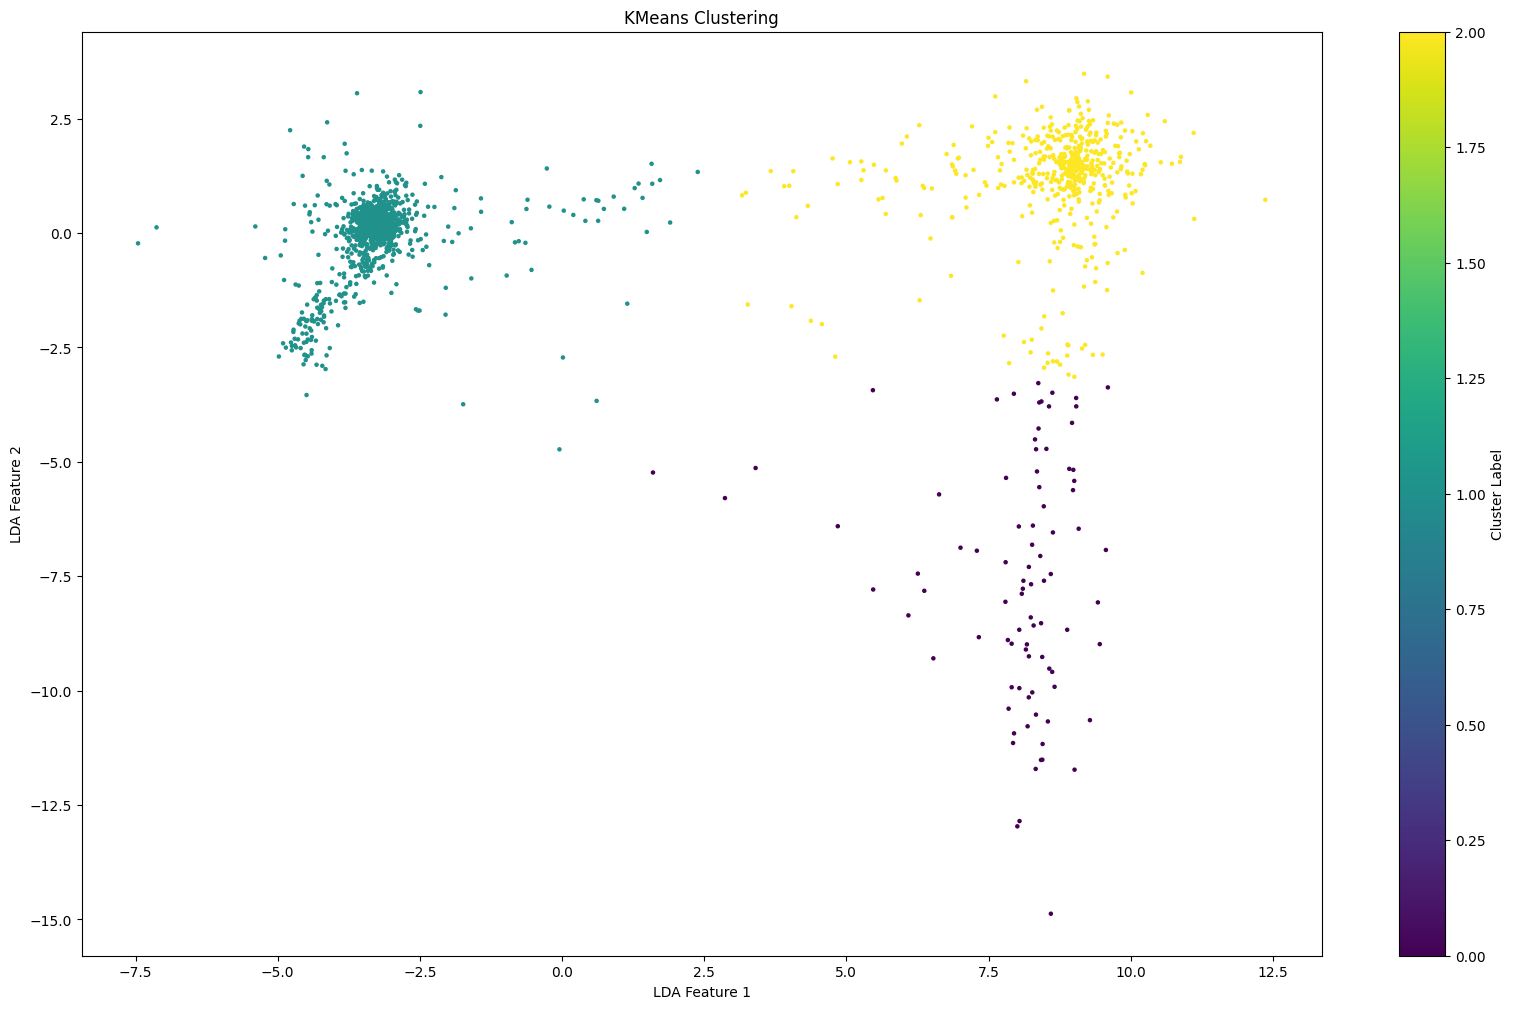

Best Cluster: 1
(2, 0.4956647398843931, 0.19055555555555556, 0.49095428959414766, 2.0390895953757227, 2.5, 0.4956647398843931)
Calculate clustering using 5 clusters
Performing clustering...


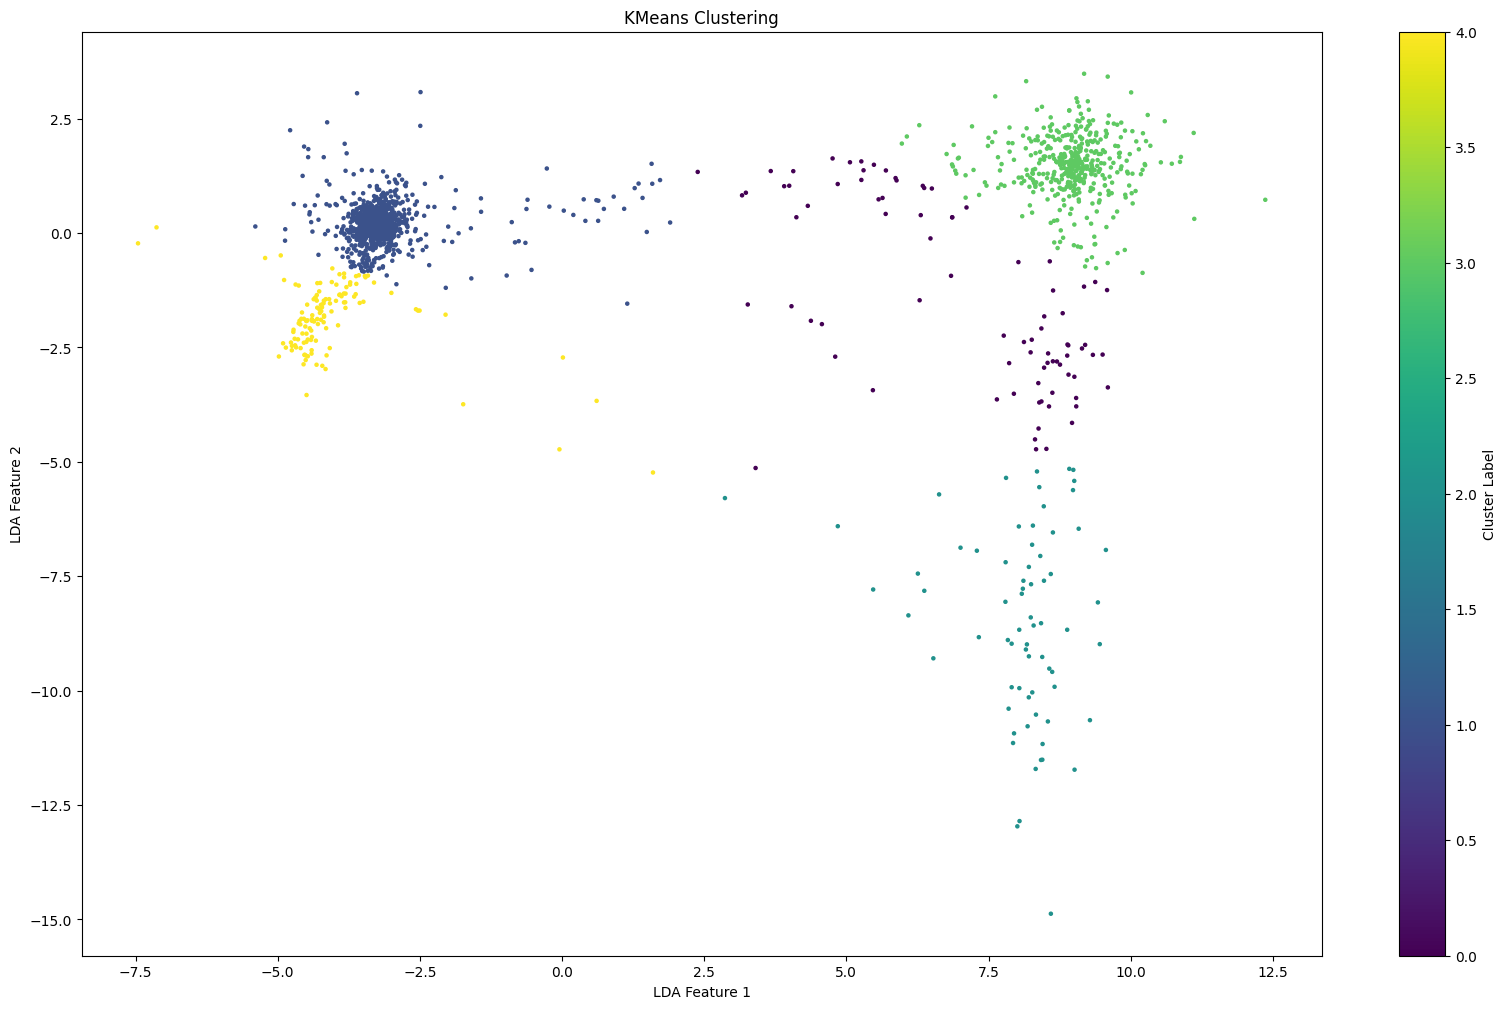

Best Cluster: 1
(1, 1.0, 0.15032377428307123, 0.13067953357458786, 1.9916153846153846, 2.8, 0.4461538461538462)
Calculate clustering using 7 clusters
Performing clustering...


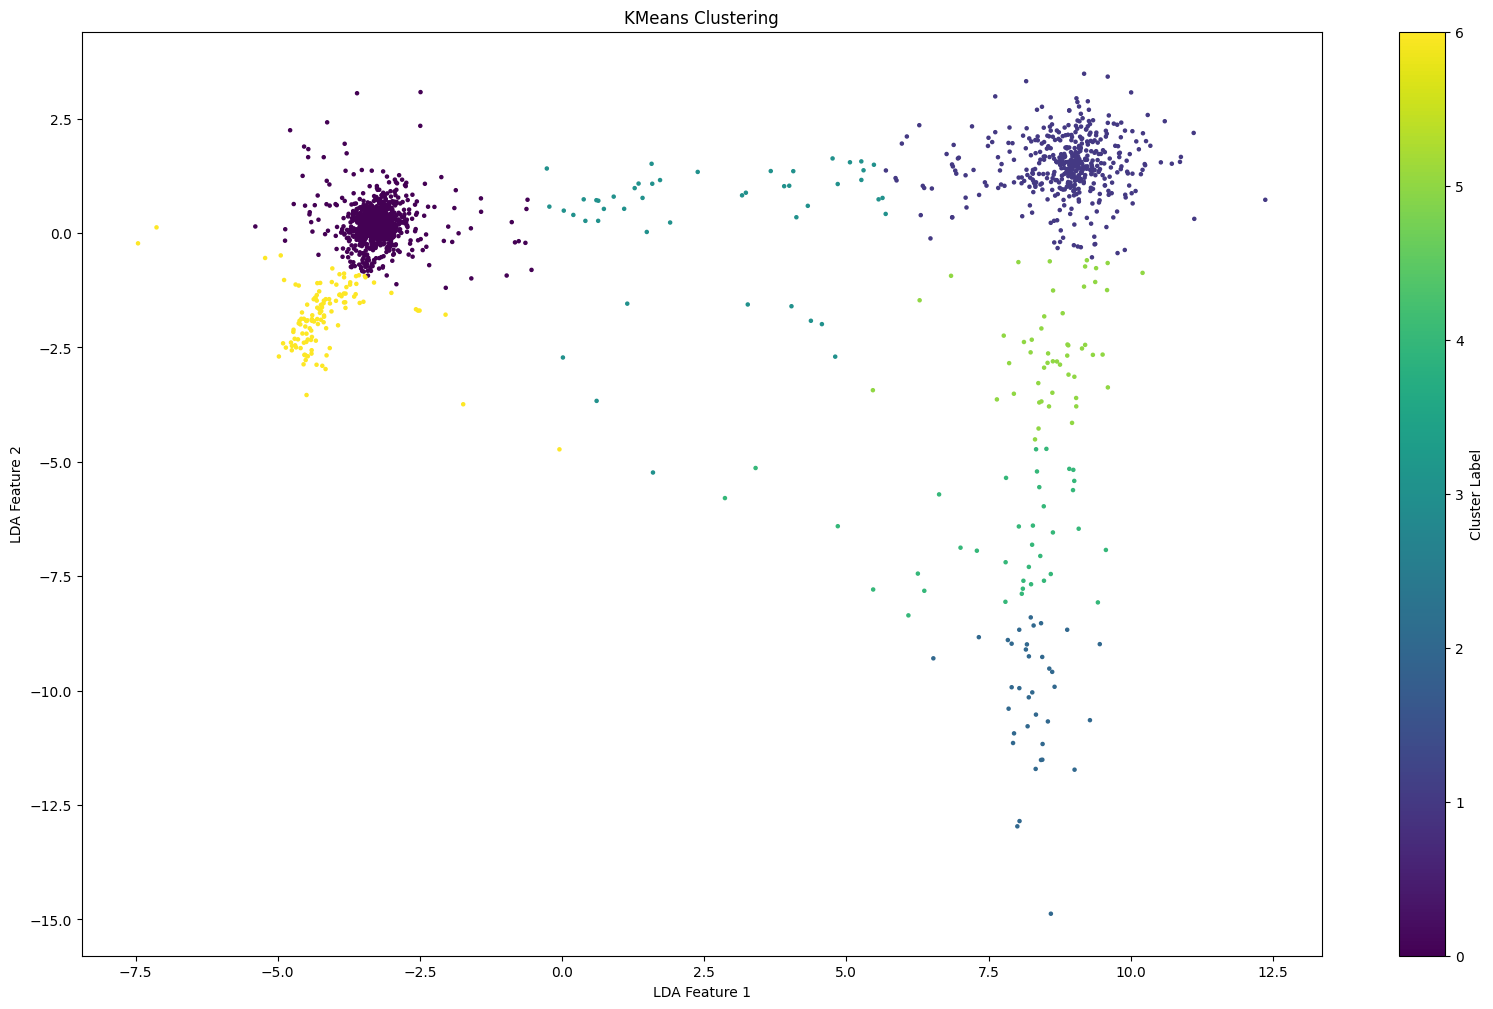

Best Cluster: 0
(1, 1.0, 0.1498612395929695, 0.13032984714400644, 1.3867283950617284, 2.05, 0.07253086419753087)
Calculate clustering using 9 clusters
Performing clustering...


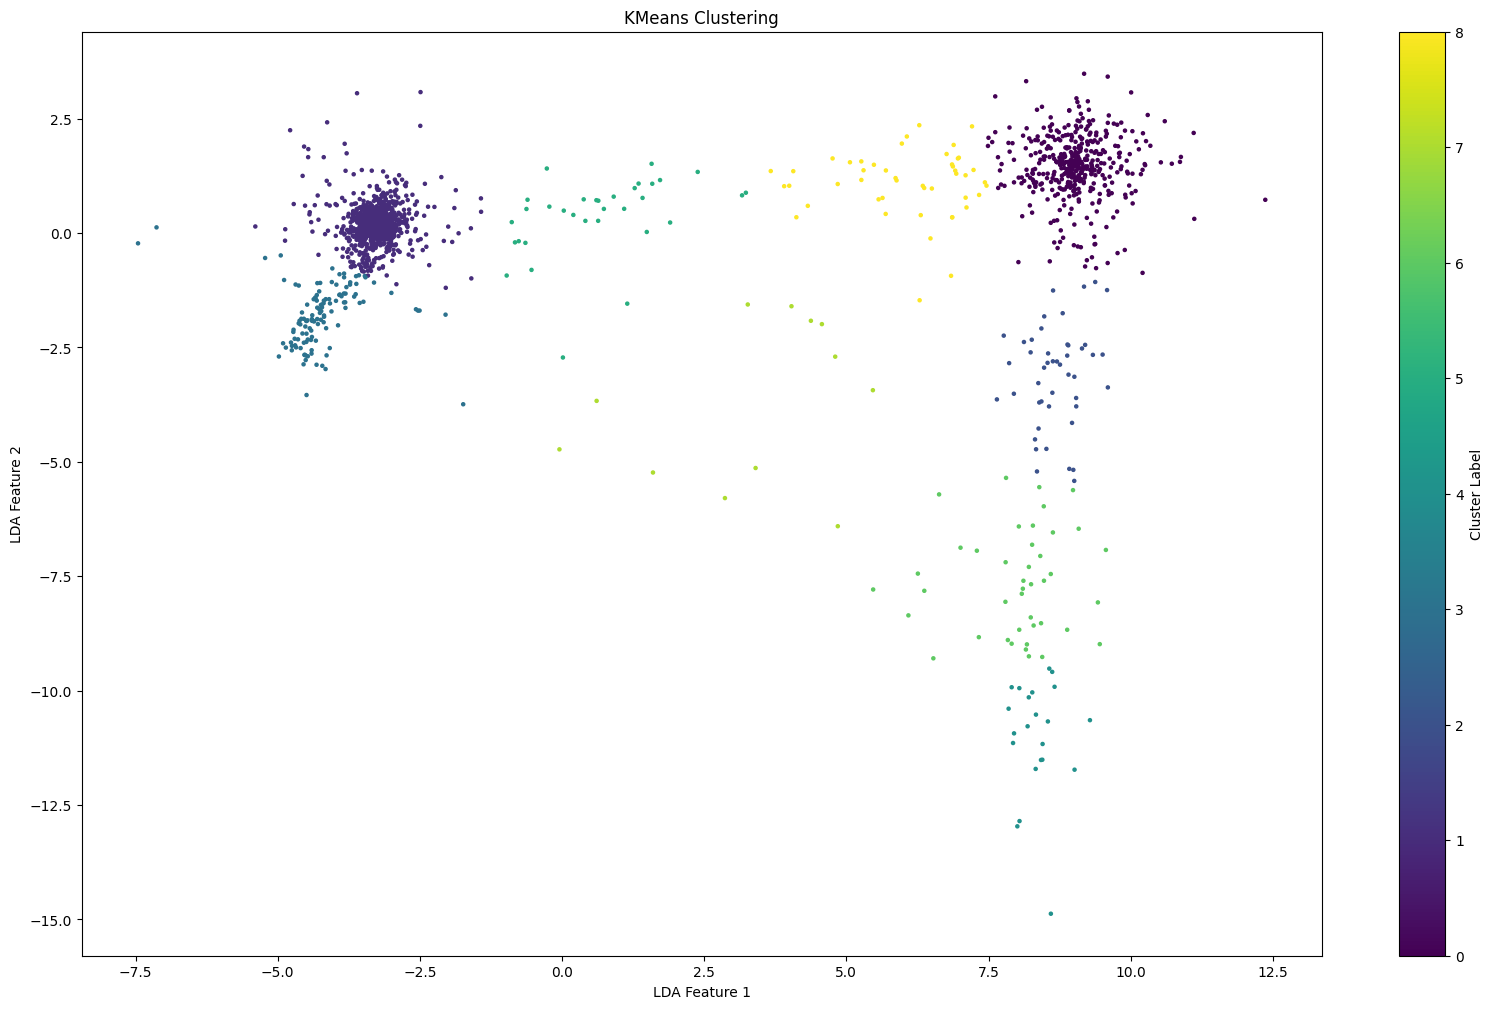

Best Cluster: 1
(1, 1.0, 0.1498612395929695, 0.13032984714400644, 1.3867283950617284, 2.05, 0.07253086419753087)
Calculate clustering using 11 clusters
Performing clustering...


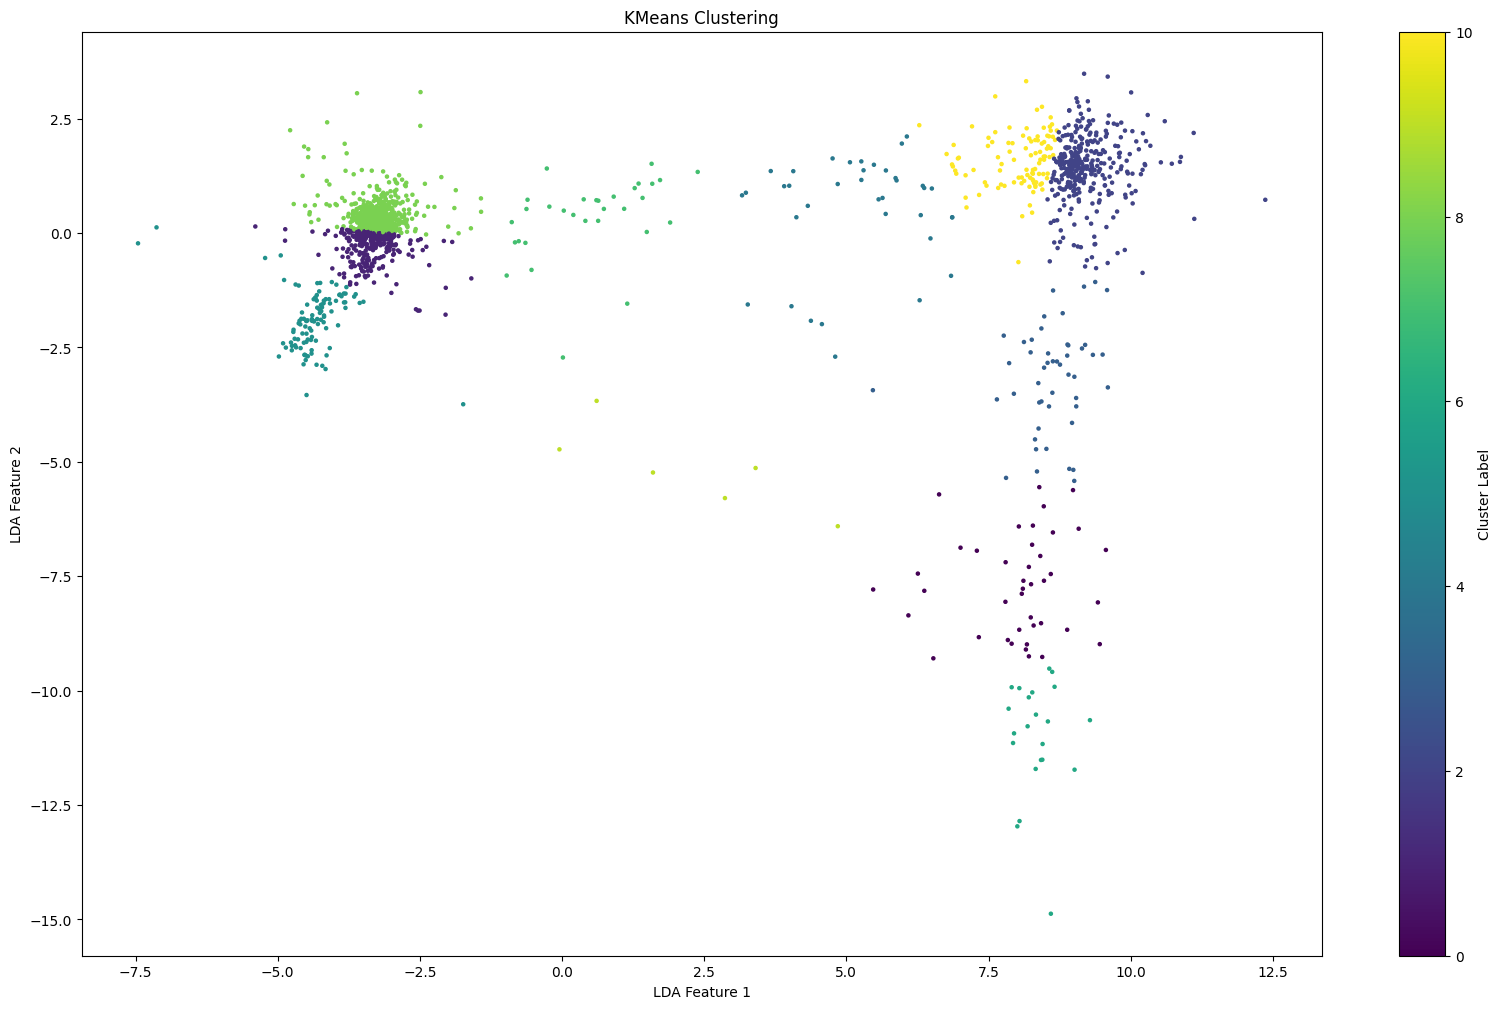

Best Cluster: 8
(1, 1.0, 0.1498612395929695, 0.13032984714400644, 1.3867283950617284, 2.05, 0.07253086419753087)
Calculate clustering using 13 clusters
Performing clustering...


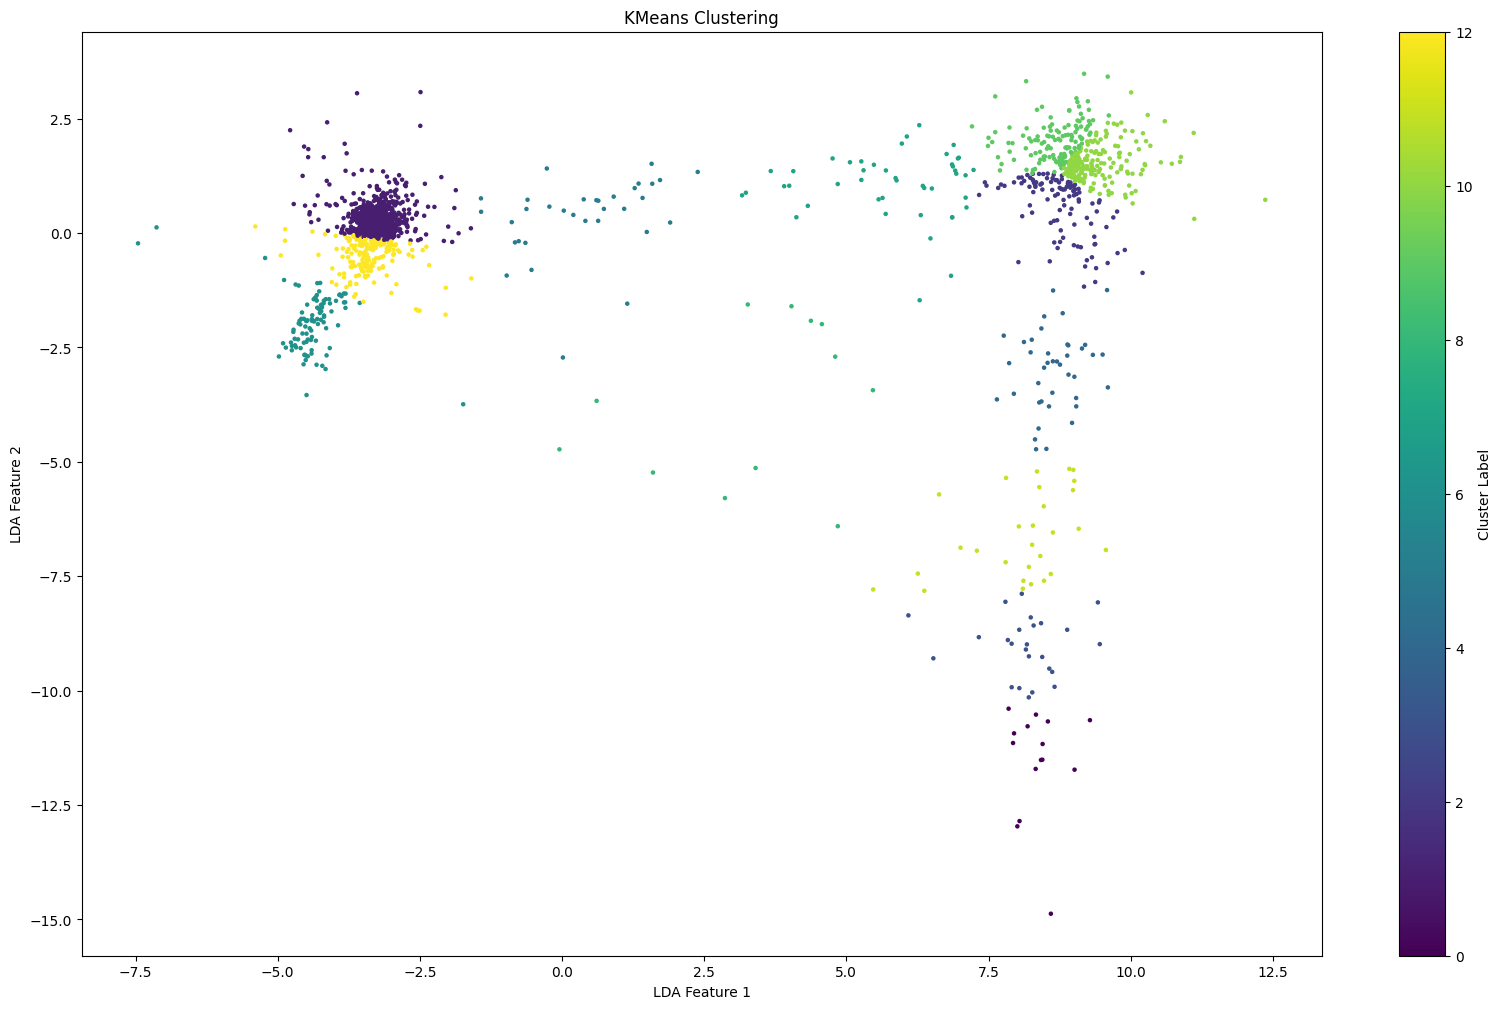

Best Cluster: 1
(1, 1.0, 0.1498612395929695, 0.13032984714400644, 1.3867283950617284, 2.05, 0.07253086419753087)
Calculate clustering using 15 clusters


In [280]:
videoSumm2(annotation_path, info_path, video_path, summary_video_path, video_list)

### TASK
* googleNet dataloader gia feature extraction
* spase ta dedomena ena ena
* video summary
    *  vriskw ena tropo na kanw output simantikotita toy frame 
    * afoy ginei ayto kanw ton alg knapsack afoy prepei nanai 15% toy arxikoy video DONE
    *  meta to evaluation pairnw analoga ta shots
    *  san weight posa frame exei to plano
    *  epiligei plano 1-3-5 px kai meta pas sto groundtruth kai tote fscore
    * analoga to plano m.o.=avg.scoring kai weight=frames in plano
### Learning
* Cluster alg macmini - isodata xwris num_clustering
* object gia titlo sygkrisi -> evaluation -> dianisma titloy,  dianisma leji gata 
    * an pareis titlo kai objects me idio tokenazier idio lejilogio me diansimatiko xoro. DONE
    * meta me eyklidia apostasi, poies lejeis einai pio konta stin anaparastasi toy titloy kai met ranking
    * object me titlo, meta lew oti opoio frame exei objects me ipsilo ranking kai norm gia 0-1
    * rank - > pio kontino object titlo pairnei rank 1. endiamesa kanoyn scale analoga ta max kai min
    * poia frame exoyn ayto to object ai pairnoyn rank
